In [34]:
%pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [35]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import os
from kaggle_secrets import UserSecretsClient
from tqdm import tqdm


In [36]:
from tqdm import tqdm

In [37]:
user_secrets = UserSecretsClient()
os.environ['hf_token'] = user_secrets.get_secret("HF_TOKEN")
os.environ['WANDB_API_KEY'] = user_secrets.get_secret("WANDB_TOKEN")
assert(os.getenv('hf_token'))
assert(os.getenv('WANDB_API_KEY'))

In [38]:

# 1. Load tokenizer and base model
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(model_name)
base_model = base_model.to("cuda" if torch.cuda.is_available() else "cpu")
base_model.eval()


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [39]:

# 2. Load prefix-tuned model from Hugging Face Hub and merge with base
peft_repo = "rtweera/qwen25-0.5b-prefix-tuning"  
peft_config = PeftConfig.from_pretrained(peft_repo)
peft_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path)
peft_model = PeftModel.from_pretrained(peft_model, peft_repo)
peft_model = peft_model.to("cuda" if torch.cuda.is_available() else "cpu")
peft_model.eval()


PeftModelForCausalLM(
  (base_model): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151936, 896)
      (layers): ModuleList(
        (0-23): 24 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear(in_features=896, out_features=896, bias=True)
            (k_proj): Linear(in_features=896, out_features=128, bias=True)
            (v_proj): Linear(in_features=896, out_features=128, bias=True)
            (o_proj): Linear(in_features=896, out_features=896, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
            (up_proj): Linear(in_features=896, out_features=4864, bias=False)
            (down_proj): Linear(in_features=4864, out_features=896, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        )
      )

In [40]:

# 3. Prepare test set (same as in your notebook)
dataset = load_dataset('squad')
def preprocess(example_batch):
    prompt = 'Generate a question from this given context:'
    inputs = [f'{prompt} {context} -> {question}' for context, question in zip(example_batch['context'], example_batch['question'])]
    tokenized = tokenizer(
        inputs,
        max_length=256,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    tokenized['labels'] = tokenized['input_ids'].clone()
    return tokenized

tokenized = dataset.map(preprocess, batched=True, remove_columns=dataset['train'].column_names)
shuffled_val = tokenized['validation'].shuffle(seed=42)
test_set = shuffled_val.select(range(40, len(shuffled_val)))
upper_bound = 20
test_set = test_set.select(range(upper_bound))


In [41]:

# 4. Generation function
def generate_question(context, model, tokenizer, max_new_tokens=30):
    input_text = f"Generate a question from this given context: {context} -> "
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=256,
        truncation=True
    ).to(model.device)
    question_ids = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        num_beams=4,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id
    )
    question = tokenizer.decode(question_ids[0], skip_special_tokens=True)
    question = question.split("->")[-1].strip()
    return question

# 5. Evaluate both models
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
test_dataset = dataset['validation'].select(range(40, len(dataset['validation'])))
test_dataset = test_dataset.shuffle(seed=42)
test_dataset = test_dataset.select(range(upper_bound))
contexts = [drow['context'] for drow in test_dataset]
references = [drow['question'] for drow in test_dataset]

def evaluate(model, tokenizer, contexts, references):
    bleu_scores = []
    rouge_scores = []
    for context, reference in tqdm(zip(contexts, references), total=len(contexts), desc='Evaluating'):
        pred = generate_question(context, model, tokenizer)
        bleu = sentence_bleu([reference.split()], pred.split())
        rouge = scorer.score(reference, pred)["rougeL"].fmeasure
        bleu_scores.append(bleu)
        rouge_scores.append(rouge)
    return bleu_scores, rouge_scores


In [42]:
for row in test_dataset:
    print(row)

{'id': '571161092419e314009555d7', 'title': 'Steam_engine', 'context': 'It is possible to use a mechanism based on a pistonless rotary engine such as the Wankel engine in place of the cylinders and valve gear of a conventional reciprocating steam engine. Many such engines have been designed, from the time of James Watt to the present day, but relatively few were actually built and even fewer went into quantity production; see link at bottom of article for more details. The major problem is the difficulty of sealing the rotors to make them steam-tight in the face of wear and thermal expansion; the resulting leakage made them very inefficient. Lack of expansive working, or any means of control of the cutoff is also a serious problem with many such designs.[citation needed]', 'question': 'What is an example of a rotary engine without pistons?', 'answers': {'text': ['Wankel', 'Wankel', 'the Wankel engine'], 'answer_start': [82, 82, 78]}}
{'id': '56e08f4a231d4119001ac2ba', 'title': 'Nikola_

In [43]:

print("Evaluating base model...")
base_bleu, base_rouge = evaluate(base_model, tokenizer, contexts, references)


Evaluating base model...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Evaluating:   5%|▌         | 1/20 [00:01<00:19,  1.01s/it]/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlap

In [44]:

print("Evaluating prefix-tuned model...")
peft_bleu, peft_rouge = evaluate(peft_model, tokenizer, contexts, references)


Evaluating prefix-tuned model...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:1889: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")
Evaluating: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


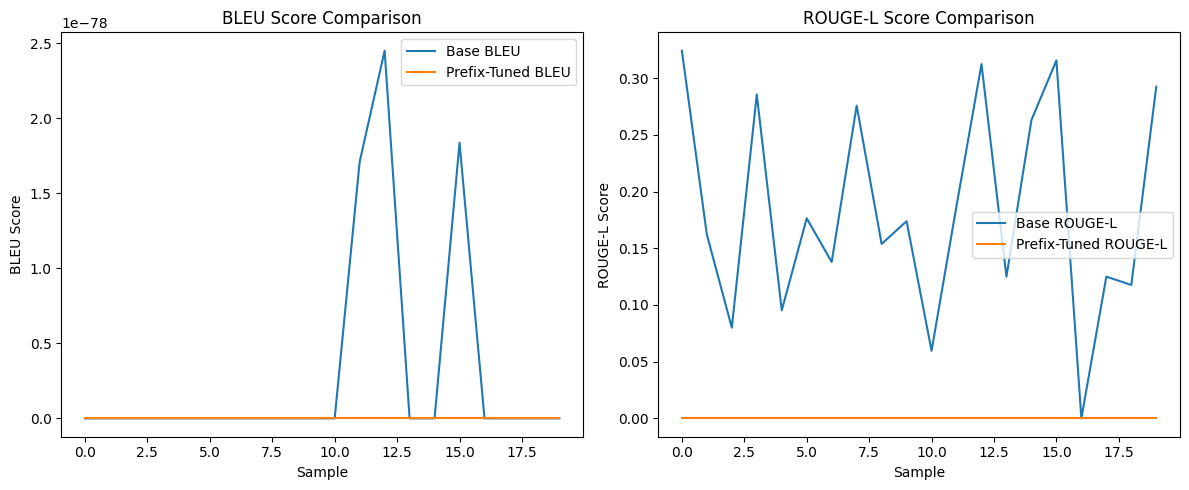

Base Model BLEU avg: 0.0000, ROUGE-L avg: 0.1832
Prefix-Tuned Model BLEU avg: 0.0000, ROUGE-L avg: 0.0000


In [45]:

# 6. Plot results
x = np.arange(len(base_bleu))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x, base_bleu, label="Base BLEU")
plt.plot(x, peft_bleu, label="Prefix-Tuned BLEU")
plt.xlabel("Sample")
plt.ylabel("BLEU Score")
plt.legend()
plt.title("BLEU Score Comparison")

plt.subplot(1,2,2)
plt.plot(x, base_rouge, label="Base ROUGE-L")
plt.plot(x, peft_rouge, label="Prefix-Tuned ROUGE-L")
plt.xlabel("Sample")
plt.ylabel("ROUGE-L Score")
plt.legend()
plt.title("ROUGE-L Score Comparison")

plt.tight_layout()
plt.show()

print(f"Base Model BLEU avg: {np.mean(base_bleu):.4f}, ROUGE-L avg: {np.mean(base_rouge):.4f}")
print(f"Prefix-Tuned Model BLEU avg: {np.mean(peft_bleu):.4f}, ROUGE-L avg: {np.mean(peft_rouge):.4f}")

In [46]:
# Pick a few sample indices from your test set
sample_indices = [i for i in range(10)]  # Change these to any indices you want to inspect

for idx in sample_indices:
    context = contexts[idx]
    reference = references[idx]
    print(f"\nSample {idx}")
    print("Context:", context)
    print("Reference Question:", reference)
    
    base_pred = generate_question(context, base_model, tokenizer)
    print("Base Model Prediction:", base_pred)
    
    peft_pred = generate_question(context, peft_model, tokenizer)
    print("PEFT Model Prediction:", peft_pred)


Sample 0
Context: It is possible to use a mechanism based on a pistonless rotary engine such as the Wankel engine in place of the cylinders and valve gear of a conventional reciprocating steam engine. Many such engines have been designed, from the time of James Watt to the present day, but relatively few were actually built and even fewer went into quantity production; see link at bottom of article for more details. The major problem is the difficulty of sealing the rotors to make them steam-tight in the face of wear and thermal expansion; the resulting leakage made them very inefficient. Lack of expansive working, or any means of control of the cutoff is also a serious problem with many such designs.[citation needed]
Reference Question: What is an example of a rotary engine without pistons?
Base Model Prediction: What is the name of the mechanism based on a pistonless rotary engine such as the Wankel engine in place of the cylinders and valve gear of
PEFT Model Prediction: HumanHuman

In [47]:
contexts[100]

IndexError: list index out of range